In [1]:
%pip install torch torchvision timm scikit-learn matplotlib Pillow opencv-python solo-learn
%pip install torch torchvision timm matplotlib opencv-python



  Using cached solo_learn-1.0.2-py3-none-any.whl.metadata (1.1 kB)
INFO: pip is looking at multiple versions of solo-learn to determine which version is compatible with other requirements. This could take a while.
  Using cached timm-1.0.15-py3-none-any.whl.metadata (52 kB)
  Using cached timm-1.0.14-py3-none-any.whl.metadata (50 kB)
  Using cached timm-1.0.13-py3-none-any.whl.metadata (53 kB)
  Using cached timm-1.0.12-py3-none-any.whl.metadata (51 kB)
  Using cached timm-1.0.11-py3-none-any.whl.metadata (48 kB)
  Using cached timm-1.0.10-py3-none-any.whl.metadata (48 kB)
  Using cached timm-1.0.9-py3-none-any.whl.metadata (42 kB)
INFO: pip is still looking at multiple versions of solo-learn to determine which version is compatible with other requirements. This could take a while.
  Using cached timm-1.0.8-py3-none-any.whl.metadata (53 kB)
  Using cached timm-1.0.7-py3-none-any.whl.metadata (47 kB)
  Using cached timm-1.0.3-py3-none-any.whl.metadata (43 kB)
  Using cached timm-0.9.16-

ERROR: Cannot install solo-learn==1.0.2, timm==0.1.1, torch and torchvision==0.15.1 because these package versions have conflicting dependencies.

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 🔧 2. Imports
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from timm import create_model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 🧠 3. Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# 📁 4. Define Data Directory
data_dir = "./data"  # Make sure this contains train/val/test with fire/no-fire

# 🔄 5. Transforms
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [4]:
# 📊 6. Load Datasets
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_train)
val_data   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_test)
test_data  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
print("Classes:", class_names)

Classes: ['fire', 'nofire']


In [5]:
# 🧠 7. Load Pretrained ViT
from timm import create_model
model = create_model('vit_tiny_patch16_224', pretrained=True, num_classes=2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [6]:
# 🔁 8. Training Function
def train(model, loader):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [7]:
# 🧪 9. Evaluation Function
def evaluate(model, loader, title="Validation"):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels)
    print(f"📈 {title} Results")
    print(classification_report(all_labels, all_preds, target_names=class_names))


In [8]:
# Freeze all except classifier
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

# Faster training loop
for epoch in range(3):  # reduced from 5
    loss = train(model, train_loader)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")
    evaluate(model, val_loader)

# Save
torch.save(model.state_dict(), 'vit_forest_fire.pth')


AssertionError: Input height (128) doesn't match model (224).

In [ ]:
from sklearn.metrics import accuracy_score

def test_accuracy(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"✅ Test Accuracy: {acc * 100:.2f}%")
    return acc

In [ ]:
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform_test)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [ ]:
test_accuracy(model, test_loader)

✅ Test Accuracy: 94.82%


0.9481981981981982

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21044\545562571.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vit_forest_fire.pth', map

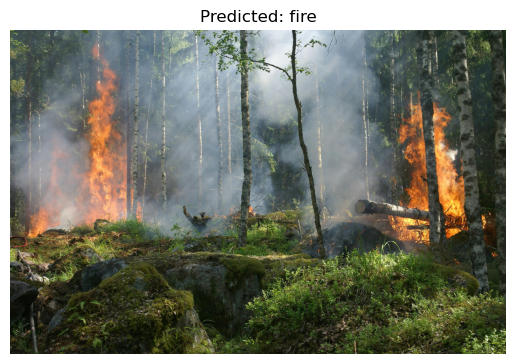

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from timm import create_model
import os

# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Recreate same model
model = create_model('vit_tiny_patch16_224', pretrained=False, num_classes=2)
model.load_state_dict(torch.load('vit_forest_fire.pth', map_location=device))
model = model.to(device)
model.eval()

# ✅ Use same transform as in validation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Load a sample image from val set (change path if needed)
img_path = 'data/val/pexels-pixabay-51951.jpg'  # <- Change to any image in val/fire or val/no-fire
img = Image.open(img_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# 🔍 Inference
with torch.no_grad():
    output = model(input_tensor)
    predicted = torch.argmax(output, dim=1).item()

# 🔤 Decode prediction
class_names = ['fire', 'no-fire']
label = class_names[predicted]

# 🖼️ Show image with prediction
plt.imshow(img)
plt.title(f"Predicted: {label}")
plt.axis('off')
plt.show()

In [ ]:
%pip install git+https://github.com/jacobgil/vit-explain



  Cloning https://github.com/jacobgil/vit-explain to c:\users\lenovo\appdata\local\temp\pip-req-build-5v1i2zp7
  Resolved https://github.com/jacobgil/vit-explain to commit 15a81d355a5aa6128ea4e71bbd56c28888d0f33b


  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/vit-explain 'C:\Users\Lenovo\AppData\Local\Temp\pip-req-build-5v1i2zp7'

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: git+https://github.com/jacobgil/vit-explain does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 🧪 Use your validation or test DataLoader
true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:  # or test_loader
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# 🧮 Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[246   4]
 [ 21 170]]


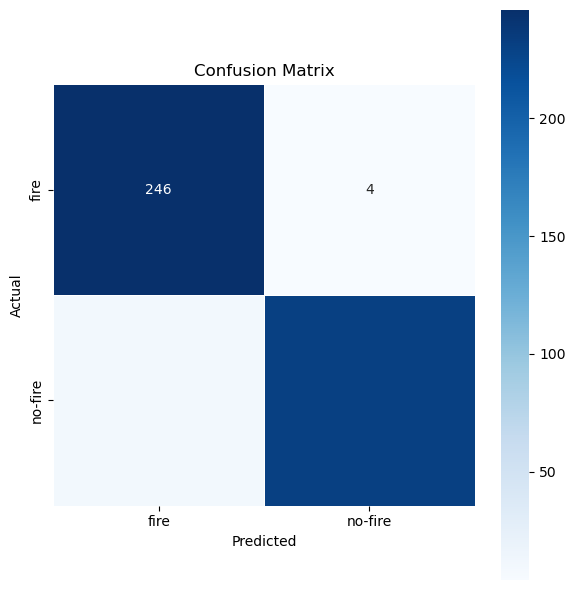

In [ ]:
class_names = ['fire', 'no-fire']  # Adjust if needed
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=True, square=True, linewidths=0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


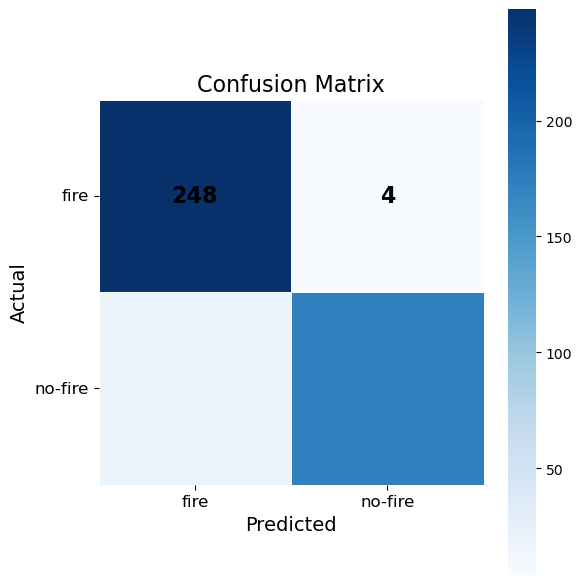

In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ✅ Your DataLoader
loader = test_loader  # or test_loader
model.eval()

all_preds = []
all_labels = []

# ✅ Collect all predictions and labels
with torch.no_grad():
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = ['fire', 'no-fire']

# ✅ Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 16, "weight": "bold", "color": "black"},
            cbar=True, square=True, linewidths=0.5)

plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

# ✅ Collect true and predicted labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:  # or test_loader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Confusion matrix values
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[248   4]
 [ 19 173]]


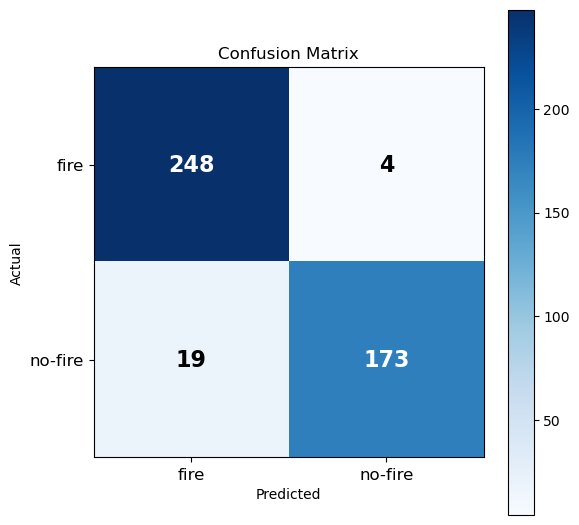

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Replace with your actual values from cm
cm = np.array([[248, 4],
               [19, 173]])
class_names = ['fire', 'no-fire']

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

# ✅ Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=16, fontweight='bold')

# ✅ Labels and ticks
ax.set(xticks=np.arange(len(class_names)),
       yticks=np.arange(len(class_names)),
       xticklabels=class_names,
       yticklabels=class_names,
       ylabel='Actual',
       xlabel='Predicted',
       title='Confusion Matrix')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.colorbar(im)
plt.show()

In [ ]:
%pip install git+https://github.com/jacobgil/vit-explain


  Cloning https://github.com/jacobgil/vit-explain to c:\users\lenovo\appdata\local\temp\pip-req-build-uzj3rqa5
  Resolved https://github.com/jacobgil/vit-explain to commit 15a81d355a5aa6128ea4e71bbd56c28888d0f33b
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/vit-explain 'C:\Users\Lenovo\AppData\Local\Temp\pip-req-build-uzj3rqa5'

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: git+https://github.com/jacobgil/vit-explain does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7432\1589149729.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

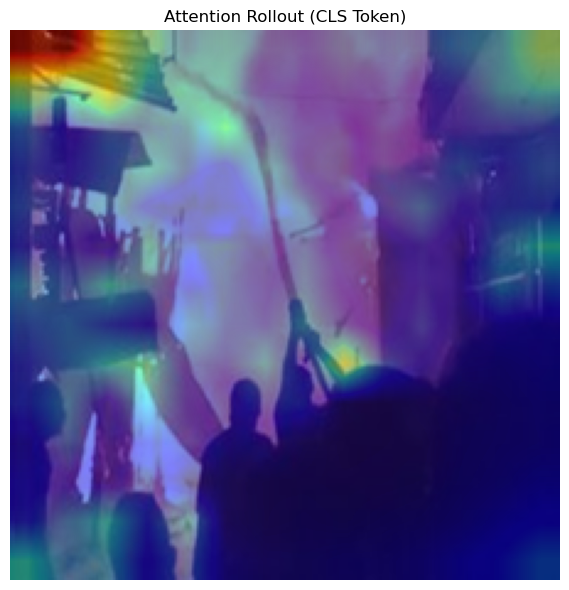

In [9]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from timm import create_model
import numpy as np
import cv2

# -----------------------------
# Configs
# -----------------------------
image_path = 'data/val/fire/0017.png'
model_path = 'vit_forest_fire.pth'
model_name = 'vit_tiny_patch16_224'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(model_name, pretrained=False, num_classes=2)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device).eval()

# -----------------------------
# Preprocess image
# -----------------------------
img = Image.open(image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
input_tensor = transform(img).unsqueeze(0).to(device)

# -----------------------------
# Hook to manually compute attention from Q and K
# -----------------------------
attn_weights = []

def get_attention_hook(module, input, output):
    try:
        x = input[0].detach().cpu()  # input token sequence
        B, N, C = x.shape
        qkv = module.qkv(x)
        qkv = qkv.reshape(B, N, 3, -1).permute(2, 0, 1, 3)
        q, k, _ = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * (1.0 / (q.shape[-1] ** 0.5))
        attn = attn.softmax(dim=-1)
        attn_weights.append(attn.cpu().detach())
    except Exception as e:
        print("Attention hook error:", e)


# Register hook on each attention layer
for blk in model.blocks:
    blk.attn.register_forward_hook(get_attention_hook)

# -----------------------------
# Forward pass
# -----------------------------
attn_weights.clear()
with torch.no_grad():
    _ = model(input_tensor)

# -----------------------------
# Compute attention rollout
# -----------------------------
def compute_rollout(attn_weights):
    result = torch.eye(attn_weights[0].size(-1)).to(device)  # Identity [tokens, tokens]
    for attn in attn_weights:
        attn = attn.squeeze(0)  # [tokens, tokens]
        attn += torch.eye(attn.shape[0]).to(device)
        attn /= attn.sum(dim=-1, keepdim=True)
        result = attn @ result
    return result[0, 1:]  # CLS token to all others

rollout = compute_rollout(attn_weights)
num_patches = rollout.shape[0]
side = int(num_patches ** 0.5)
rollout_map = rollout.reshape(side, side).cpu().numpy()
rollout_resized = cv2.resize(rollout_map, (224, 224))

# -----------------------------
# Visualize
# -----------------------------
plt.figure(figsize=(6, 6))
plt.imshow(img.resize((224, 224)))
plt.imshow(rollout_resized, cmap='jet', alpha=0.5)
plt.title("Attention Rollout (CLS Token)")
plt.axis('off')
plt.tight_layout()
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7432\1684894879.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vit_forest_fire.pth', map

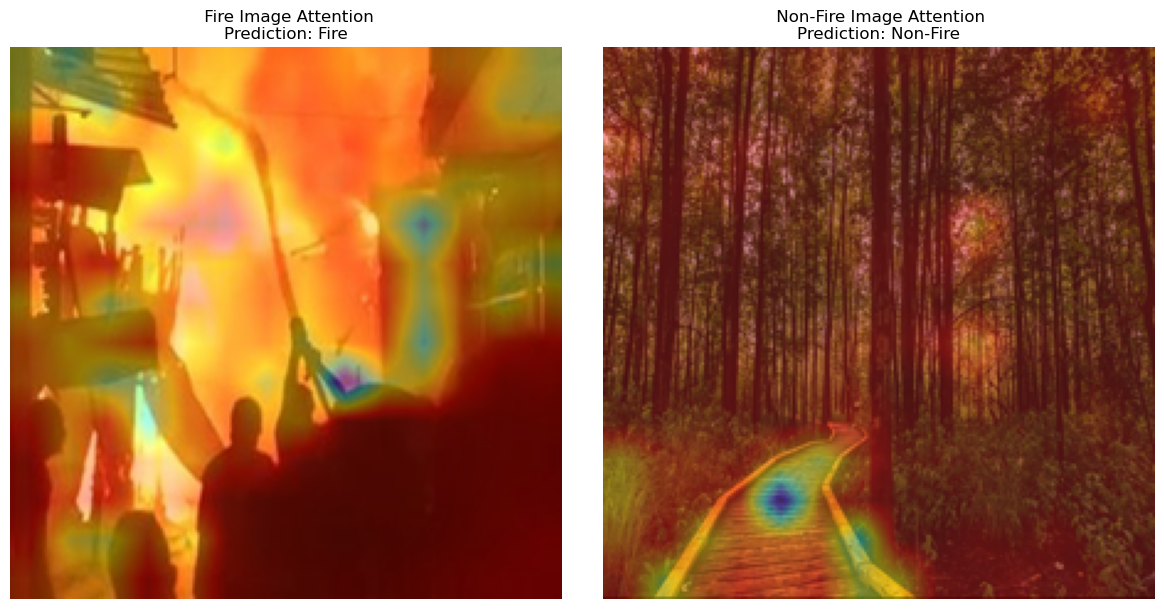

In [15]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from timm import create_model
import numpy as np
import cv2

# -----------------------------
# Load model
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model('vit_tiny_patch16_224', pretrained=False, num_classes=2)
model.load_state_dict(torch.load('vit_forest_fire.pth', map_location=device))
model.to(device).eval()

# -----------------------------
# Image Preprocessing
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def load_image(path):
    img = Image.open(path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)
    return img, input_tensor

# -----------------------------
# Attention Extraction Hook
# -----------------------------
def extract_attention(input_tensor):
    attn_weights = []

    def get_attention_hook(module, input, output):
        x = input[0].detach()
        B, N, C = x.shape
        qkv = module.qkv(x)
        qkv = qkv.reshape(B, N, 3, -1).permute(2, 0, 1, 3)
        q, k, _ = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * (1.0 / (q.shape[-1] ** 0.5))
        attn = attn.softmax(dim=-1)
        attn_weights.append(attn.cpu().detach())

    # Register hooks
    hooks = []
    for blk in model.blocks[:6]:  # reduce memory use
        h = blk.attn.register_forward_hook(get_attention_hook)
        hooks.append(h)

    with torch.no_grad():
        model(input_tensor)

    for h in hooks:
        h.remove()

    return attn_weights

# -----------------------------
# Compute Attention Rollout
# -----------------------------
def compute_rollout(attn_weights):
    result = torch.eye(attn_weights[0].size(-1))
    for attn in attn_weights:
        attn = attn.squeeze(0)
        attn += torch.eye(attn.shape[-1])
        attn /= attn.sum(dim=-1, keepdim=True)
        result = attn @ result
    return result[0, 1:]

# -----------------------------
# Generate Overlay Map
# -----------------------------
def generate_attention_overlay(img_pil, input_tensor):
    attn = extract_attention(input_tensor)
    rollout = compute_rollout(attn)
    num_patches = rollout.shape[0]
    side = int(num_patches ** 0.5)
    rollout_map = rollout.reshape(side, side).numpy()

    # Normalize heatmap
    rollout_map -= rollout_map.min()
    rollout_map /= rollout_map.max()

    rollout_resized = cv2.resize(rollout_map, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * rollout_resized), cv2.COLORMAP_JET)

    img_np = np.array(img_pil.resize((224, 224))).astype(np.uint8)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)
    return overlay, rollout_resized

# -----------------------------
# Predict Label from Model
# -----------------------------
def predict_label(input_tensor):
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
        label = "Non-Fire" if pred == 1 else "Fire"
    return label

# -----------------------------
# Compare Fire and Non-Fire
# -----------------------------
fire_img_path = 'data/val/fire/0017.png'         # 🔥 update as needed
non_fire_img_path = 'data/val/nofire/0042.png' # 🚫 update as needed

fire_img, fire_tensor = load_image(fire_img_path)
non_fire_img, non_fire_tensor = load_image(non_fire_img_path)

fire_overlay, _ = generate_attention_overlay(fire_img, fire_tensor)
non_fire_overlay, _ = generate_attention_overlay(non_fire_img, non_fire_tensor)

fire_label = predict_label(fire_tensor)
non_fire_label = predict_label(non_fire_tensor)

# -----------------------------
# Display Side by Side
# -----------------------------
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(fire_overlay)
plt.title(f" Fire Image Attention\nPrediction: {fire_label}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(non_fire_overlay)
plt.title(f" Non-Fire Image Attention\nPrediction: {non_fire_label}")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from timm import create_model
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# -----------------------------
# Load ViT Model
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model('vit_tiny_patch16_224', pretrained=False, num_classes=2)
model.load_state_dict(torch.load('vit_forest_fire.pth', map_location=device))
model = model.to(device).eval()

# -----------------------------
# Attention Rollout (fixed hook on qkv)
# -----------------------------
def get_attention_rollout(input_tensor):
    attn_weights = []

    def hook_fn(module, input, output):
        # Reconstruct attention from qkv inside the attention module
        x = input[0]  # [B, N, C]
        B, N, C = x.shape
        qkv = module.qkv(x).reshape(B, N, 3, module.num_heads, C // module.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * module.scale
        attn = attn.softmax(dim=-1)
        attn_weights.append(attn.detach())

    # Register hook on the full Attention module
    handles = []
    for blk in model.blocks:
        handles.append(blk.attn.register_forward_hook(hook_fn))

    with torch.no_grad():
        _ = model(input_tensor)

    for h in handles:
        h.remove()

    if not attn_weights:
        raise RuntimeError("❌ Attention weights not captured. Check hook or model.")

    # Rollout computation
    result = torch.eye(attn_weights[0].size(-1)).to(device)
    for attn in attn_weights:
        attn = attn.squeeze(0)  # [heads, tokens, tokens]
        attn_heads_fused = attn.mean(dim=0)
        attn_heads_fused += torch.eye(attn_heads_fused.size(0)).to(device)
        attn_heads_fused /= attn_heads_fused.sum(dim=-1, keepdim=True)
        result = attn_heads_fused @ result

    rollout = result[0, 1:].reshape(14, 14).cpu().numpy()  # remove CLS token
    return rollout


# -----------------------------
# Evaluate Attention vs Fire Mask
# -----------------------------
def evaluate_attention(image_path, mask_path, threshold=0.6):
    img = Image.open(image_path).convert("RGB")

    # Transform image for ViT
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Get attention rollout
    rollout_map = get_attention_rollout(input_tensor)
    rollout_resized = cv2.resize(rollout_map, (224, 224))

    # Normalize attention
    attn_norm = (rollout_resized - rollout_resized.min()) / (rollout_resized.max() - rollout_resized.min())
    attn_binary = attn_norm > threshold

    # Load and process binary mask
    mask = Image.open(mask_path).convert("L").resize((224, 224))
    mask = np.array(mask) > 128  # binary mask

    # Compute IoU
    intersection = np.logical_and(attn_binary, mask).sum()
    union = np.logical_or(attn_binary, mask).sum()
    iou = intersection / union if union != 0 else 0

    print(f"📏 IoU Score: {iou:.4f}")

    # Visualize attention overlay
    plt.figure(figsize=(6, 6))
    plt.imshow(img.resize((224, 224)))
    plt.imshow(attn_norm, cmap='jet', alpha=0.5)
    plt.title(f"Attention Overlay (IoU = {iou:.3f})")
    plt.axis('off')
    plt.show()

# -----------------------------
# Run Example
# -----------------------------
evaluate_attention(
    image_path='data/val/fire/0008.png',        # 🔥 Your fire image
    mask_path='data/mask/0008_mask.png'        # 🎯 Your corresponding binary mask
)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7432\3259504677.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vit_forest_fire.pth', map

AttributeError: 'Linear' object has no attribute 'num_heads'